In [22]:
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers import COBYLA, SPSA, QNSPSA, SLSQP, ADAM, GradientDescent
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

In [23]:
import tensorflow as tf
import collections
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [24]:
def filter_3649(x, y):
    keep = (y == 1) | (y == 2) | (y == 4) | (y == 9)
    x, y = x[keep], y[keep]
    # y = y == 3
    return x,y

In [25]:
x_train, y_train = filter_3649(x_train, y_train)
x_test, y_test = filter_3649(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 24491
Number of filtered test examples: 4158


4


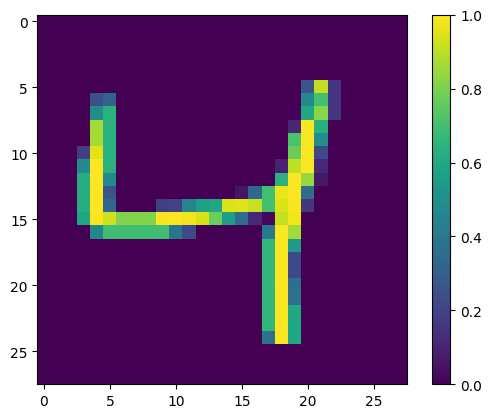

In [26]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [27]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

4


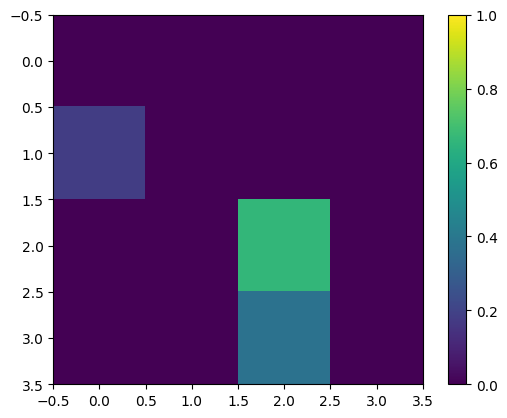

In [28]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [29]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and 3 in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and 6 in value)
    num_uniq_4 = sum(1 for value in mapping.values() if len(value) == 1 and 4 in value)
    num_uniq_9 = sum(1 for value in mapping.values() if len(value) == 1 and 9 in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) >= 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique 4s: ", num_uniq_4)
    print("Number of unique 9s: ", num_uniq_9)
    print("Number of unique contradicting labels: ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.asarray(new_x), np.asarray(new_y)

In [30]:
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 17851
Number of unique 3s:  0
Number of unique 6s:  0
Number of unique 4s:  5147
Number of unique 9s:  5423
Number of unique contradicting labels:  553

Initial number of images:  24491
Remaining non-contradicting unique images:  17298
Number of unique images: 3311
Number of unique 3s:  0
Number of unique 6s:  0
Number of unique 4s:  931
Number of unique 9s:  958
Number of unique contradicting labels:  66

Initial number of images:  4158
Remaining non-contradicting unique images:  3245


In [31]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    
  
    print("weights", weights)
    print("objective function value", objective_func_vals)
    
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [32]:
num_inputs = 16
feature_map = ZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

In [33]:
classifier = VQC(
    feature_map = feature_map,
    ansatz = ansatz,
    optimizer=COBYLA(maxiter=20, rhobeg = 5),
    callback=callback_graph)

In [34]:
x_reshaped = []
x1_reshaped = []

for b in resized_train_images:
    x_reshaped.append(b.reshape(1,16))

for b in resized_test_images:
    x1_reshaped.append(b.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
    #print("entry \n" , entry[0])
    final_x.append(entry[0])

for entry in x1_reshaped:
    #print("entry \n" , entry[0])
    final_x1.append(entry[0])

objective_func_vals = []

x = np.asarray(final_x)
y = np.asarray(train_labels)

x = x[:100]
y = y[:100]

print(x)
print(y)

[[0.         0.         0.         ... 0.         0.3764706  0.        ]
 [0.         0.         0.         ... 0.99215686 0.         0.        ]
 [0.         0.         0.         ... 0.         0.16470589 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[4 1 9 2 9 4 9 1 1 2 4 2 9 9 9 9 4 9 9 4 1 4 4 4 1 1 1 9 2 9 4 4 1 1 2 9 1
 4 9 2 2 4 4 9 1 4 4 2 4 9 9 2 2 9 4 4 4 9 9 2 9 9 1 9 2 2 2 4 9 2 1 1 2 4
 2 4 9 9 1 2 4 9 2 2 4 2 9 9 2 4 4 4 2 9 9 9 4 1 4 4]


weights [5.54585264 5.37231611 0.10872259 5.84001738 0.56200524 0.65473951
 0.97407869 0.09219047 0.57312555 0.70715096 0.26436714 0.06281523
 0.10895125 0.47332744 0.94962745 0.75533384 0.07208291 0.25580113
 0.08243225 0.41348584 0.12825175 0.11204028 0.40457779 0.85067344
 0.46306359 0.07106532 0.71991742 0.71435978 0.75839406 0.00770082
 0.23558549 0.7639279 ]
objective function value [4.57206283838811, 3.8335042014298106, 3.015545971024105, 3.0155480833231603, 3.015546735889869]


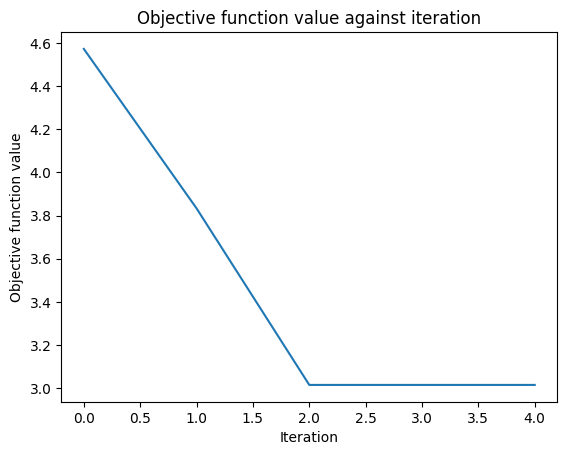

In [35]:
classifier.fit(x,y)

In [ ]:
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the train data : 60.0%


In [ ]:
x1 = np.asarray(final_x1)
y1 = np.asarray(test_labels)
        
x1 = x1[:100]
y1 = y1[:100]
y_predict = classifier.predict(x1)

print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

Accuracy from the test data : 50.0%


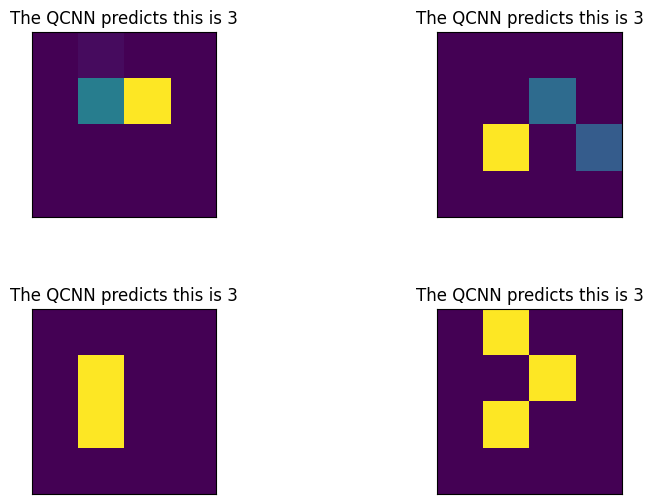

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 3:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if y_predict[i] == 6:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 6")
    if y_predict[i] == 4:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 4")   
    if y_predict[i] == 9:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 9") 
plt.subplots_adjust(wspace=0.1, hspace=0.5)